In [1]:
# imports
# I was trying a lot of different things during this notebook therefore there might be the one or two libaries which
# arn´t needed anymore


import requests                 # How Python gets the webpages
from bs4 import BeautifulSoup   # Creates structured, searchable object
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import json
from pandas import ExcelWriter
from pandas import ExcelFile
from sklearn.svm import SVR
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
from matplotlib.ticker import NullFormatter 

import datetime as dt
from datetime import date
from scipy import stats
#from pandas.core import datetools
from plotly import tools
import chart_studio.plotly as py
import plotly.figure_factory as ff
import plotly.tools as tls
import plotly.graph_objs as go
import warnings
import seaborn as sns


from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn import metrics 


import json
from time import sleep
from datetime import datetime

from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
init_notebook_mode(connected=True)
import matplotlib

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import make_moons, make_circles, make_classification
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis

from sklearn.model_selection import learning_curve, GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.metrics import classification_report, confusion_matrix # confusion matrix
from sklearn import metrics

import pandas as pd
import numpy as np
import xgboost as xgb
from xgboost.sklearn import XGBClassifier
from sklearn import  metrics   #Additional scklearn functions
from sklearn.model_selection import GridSearchCV

import matplotlib.pylab as plt
%matplotlib inline
from matplotlib.pylab import rcParams

import gc 

In [2]:
from pylab import rcParams

rcParams['figure.figsize'] = 30, 30
rcParams['font.size'] = 20
rcParams['axes.facecolor'] = 'white'

%matplotlib inline

warnings.filterwarnings("ignore")

# plt.style.available
plt.style.use("seaborn-whitegrid")

In [3]:
test_identity = pd.read_csv('..\datasets/test_identity.csv') # Source: Kaggle
test_transaction = pd.read_csv('..\datasets/test_transaction.csv') # Source: Kaggle
train_identity = pd.read_csv('..\datasets/train_identity.csv') # Source: Kaggle
train_transaction = pd.read_csv('..\datasets/train_transaction.csv') # Source: Kaggle
sample_submission = pd.read_csv('..\datasets/sample_submission.csv') # Source: Kaggle




### Reduce memory usage of data

#### There are 3 ways to handle big data
- Chunk sizing Data with csv.read() 
- Filter out unimportant columns 
- Change dtypes for columns

The last two aspects we try to apply in the next steps


### 1. Filter Out Unimportant Columns
We can eleminate some useless features already at the begining. Such as:
- Features with only 1 unique value
- Features with more than 90% missing values
- Features with the top value appears more than 90% of the time

In [4]:

# https://www.kaggle.com/nroman/recursive-feature-elimination
train = pd.merge(train_transaction, train_identity, on='TransactionID', how='left')
test = pd.merge(test_transaction, test_identity, on='TransactionID', how='left')

#del test_identity, test_transaction, train_identity, train_transaction
gc.collect()

one_value_cols = [col for col in train.columns if train[col].nunique() <= 1]
one_value_cols_test = [col for col in test.columns if test[col].nunique() <= 1]

many_null_cols = [col for col in train.columns if train[col].isnull().sum() / train.shape[0] > 0.1]
many_null_cols_test = [col for col in test.columns if test[col].isnull().sum() / test.shape[0] > 0.1]

big_top_value_cols = [col for col in train.columns if train[col].value_counts(dropna=False, normalize=True).values[0] > 0.9]
big_top_value_cols_test = [col for col in test.columns if test[col].value_counts(dropna=False, normalize=True).values[0] > 0.9]

cols_to_drop = list(set(many_null_cols + many_null_cols_test + big_top_value_cols + big_top_value_cols_test + one_value_cols + one_value_cols_test))
cols_to_drop.remove('isFraud')
print('{} features are going to be dropped for being useless'.format(len(cols_to_drop)))
# adding part of whole dataset
part = (len(cols_to_drop)/(len(train.columns)+len(test.columns))*100)
print('Thats {} % of the whole dataset '.format(round(part, 2)))

train = train.drop(cols_to_drop, axis=1)
test = test.drop(cols_to_drop, axis=1)

376 features are going to be dropped for being useless
Thats 43.37 % of the whole dataset 


### 2. Safe Memory Size by Changing Datatypes

In [5]:
#source= https://wkirgsn.github.io/2018/02/10/auto-downsizing-dtypes/
from joblib import Parallel, delayed
import gc

#__AUTHOR__ = 'Kirgsn'

class Reducer:
    """
    Class that takes a dict of increasingly big numpy datatypes to transform
    the data of a pandas dataframe to in order to save memory usage.
    """
    memory_scale_factor = 1024**2  # memory in MB

    def __init__(self, conv_table=None):
        """
        :param conv_table: dict with np.dtypes-strings as keys
        """
        if conv_table is None:
            self.conversion_table = \
                {'int': [np.int8, np.int16, np.int32, np.int64],
                 'uint': [np.uint8, np.uint16, np.uint32, np.uint64],
                 'float': [np.float16, np.float32, ]}
        else:
            self.conversion_table = conv_table
            
        #gc.collect()

    def _type_candidates(self, k):
        for c in self.conversion_table[k]:
            i = np.iinfo(c) if 'int' in k else np.finfo(c)
            yield c, i

    def reduce(self, df, verbose=False):
        """Takes a dataframe and returns it with all data transformed to the
        smallest necessary types.

        :param df: pandas dataframe
        :param verbose: If True, outputs more information
        :return: pandas dataframe with reduced data types
        """
        ret_list = Parallel(n_jobs=-1, max_nbytes=None)(delayed(self._reduce)
                                                (df[c], c, verbose) for c in
                                                df.columns)

        return pd.concat(ret_list, axis=1)

    def _reduce(self, s, colname, verbose):

        # skip NaNs
        if s.isnull().any():
            if verbose:
                print(colname, 'has NaNs - Skip..')
            return s

        # detect kind of type
        coltype = s.dtype
        if np.issubdtype(coltype, np.integer):
            conv_key = 'int' if s.min() < 0 else 'uint'
        elif np.issubdtype(coltype, np.floating):
            conv_key = 'float'
        else:
            if verbose:
                print(colname, 'is', coltype, '- Skip..')
            print(colname, 'is', coltype, '- Skip..')
            return s

        # find right candidate
        for cand, cand_info in self._type_candidates(conv_key):
            if s.max() <= cand_info.max and s.min() >= cand_info.min:

                if verbose:
                    print('convert', colname, 'to', str(cand))
                return s.astype(cand)

        # reaching this code is bad. Probably there are inf, or other high numbs
        print(("WARNING: {} " 
               "doesn't fit the grid with \nmax: {} "
               "and \nmin: {}").format(colname, s.max(), s.min()))
        print('Dropping it..')

In [6]:
reducer = Reducer()
data_test = reducer.reduce(test)

In [7]:
reducer = Reducer()
data_train = reducer.reduce(train)

In [10]:
def reduce_mem_usage(df):
    start_mem_usg = df.memory_usage().sum() / 1024**2 
    print("Memory usage of properties dataframe is :",start_mem_usg," MB")
    NAlist = [] # Keeps track of columns that have missing values filled in. 
    for col in df.columns:
        if df[col].dtype != object:  # Exclude strings            
            # Print current column type
            print("******************************")
            print("Column: ",col)
            print("dtype before: ",df[col].dtype)            
            # make variables for Int, max and min
            IsInt = False
            mx = df[col].max()
            mn = df[col].min()
            print("min for this col: ",mn)
            print("max for this col: ",mx)
            # Integer does not support NA, therefore, NA needs to be filled
            if not np.isfinite(df[col]).all(): 
                NAlist.append(col)
                df[col].fillna(mn-1,inplace=True)  
                   
            # test if column can be converted to an integer
            asint = df[col].fillna(0).astype(np.int64)
            result = (df[col] - asint)
            result = result.sum()
            if result > -0.01 and result < 0.01:
                IsInt = True            
            # Make Integer/unsigned Integer datatypes
            if IsInt:
                if mn >= 0:
                    if mx < 255:
                        df[col] = df[col].astype(np.uint8)
                    elif mx < 65535:
                        df[col] = df[col].astype(np.uint16)
                    elif mx < 4294967295:
                        df[col] = df[col].astype(np.uint32)
                    else:
                        df[col] = df[col].astype(np.uint64)
                else:
                    if mn > np.iinfo(np.int8).min and mx < np.iinfo(np.int8).max:
                        df[col] = df[col].astype(np.int8)
                    elif mn > np.iinfo(np.int16).min and mx < np.iinfo(np.int16).max:
                        df[col] = df[col].astype(np.int16)
                    elif mn > np.iinfo(np.int32).min and mx < np.iinfo(np.int32).max:
                        df[col] = df[col].astype(np.int32)
                    elif mn > np.iinfo(np.int64).min and mx < np.iinfo(np.int64).max:
                        df[col] = df[col].astype(np.int64)    
            # Make float datatypes 32 bit
            else:
                df[col] = df[col].astype(np.float32)
            
            # Print new column type
            print("dtype after: ",df[col].dtype)
            print("******************************")
    # Print final result
    print("___MEMORY USAGE AFTER COMPLETION:___")
    mem_usg = df.memory_usage().sum() / 1024**2 
    print("Memory usage is: ",mem_usg," MB")
    print("This is ",(100*mem_usg/start_mem_usg).round(2),"% of the initial size")
    return df, NAlist 

In [11]:
min_test, NAlist = reduce_mem_usage(data_test)

Memory usage of properties dataframe is : 190.3879680633545  MB
******************************
Column:  TransactionID
dtype before:  uint32
min for this col:  3663549
max for this col:  4170239
dtype after:  uint32
******************************
******************************
Column:  TransactionDT
dtype before:  uint32
min for this col:  18403224
max for this col:  34214345
dtype after:  uint32
******************************
******************************
Column:  TransactionAmt
dtype before:  float16
min for this col:  0.018
max for this col:  10270.0
dtype after:  float32
******************************
******************************
Column:  card1
dtype before:  uint16
min for this col:  1001
max for this col:  18397
dtype after:  uint16
******************************
******************************
Column:  card2
dtype before:  float64
min for this col:  100.0
max for this col:  600.0
dtype after:  uint16
******************************
******************************
Column:  card3
d

dtype after:  float32
******************************
******************************
Column:  V312
dtype before:  float64
min for this col:  0.0
max for this col:  167200.0
dtype after:  float32
******************************
******************************
Column:  V313
dtype before:  float64
min for this col:  0.0
max for this col:  4727.9599609375
dtype after:  float32
******************************
******************************
Column:  V314
dtype before:  float64
min for this col:  0.0
max for this col:  7539.75
dtype after:  float32
******************************
******************************
Column:  V315
dtype before:  float64
min for this col:  0.0
max for this col:  4727.9599609375
dtype after:  float32
******************************
******************************
Column:  V317
dtype before:  float64
min for this col:  0.0
max for this col:  958320.0
dtype after:  float32
******************************
___MEMORY USAGE AFTER COMPLETION:___
Memory usage is:  73.93238353729248  

In [12]:
min_train, NAlist = reduce_mem_usage(data_train)

Memory usage of properties dataframe is : 206.6880989074707  MB
******************************
Column:  TransactionID
dtype before:  uint32
min for this col:  2987000
max for this col:  3577539
dtype after:  uint32
******************************
******************************
Column:  isFraud
dtype before:  uint8
min for this col:  0
max for this col:  1
dtype after:  uint8
******************************
******************************
Column:  TransactionDT
dtype before:  uint32
min for this col:  86400
max for this col:  15811131
dtype after:  uint32
******************************
******************************
Column:  TransactionAmt
dtype before:  float16
min for this col:  0.251
max for this col:  31940.0
dtype after:  float32
******************************
******************************
Column:  card1
dtype before:  uint16
min for this col:  1000
max for this col:  18396
dtype after:  uint16
******************************
******************************
Column:  card2
dtype before:

dtype after:  float32
******************************
******************************
Column:  V310
dtype before:  float64
min for this col:  0.0
max for this col:  55125.0
dtype after:  float32
******************************
******************************
Column:  V312
dtype before:  float64
min for this col:  0.0
max for this col:  55125.0
dtype after:  float32
******************************
******************************
Column:  V313
dtype before:  float64
min for this col:  0.0
max for this col:  4817.47021484375
dtype after:  float32
******************************
******************************
Column:  V314
dtype before:  float64
min for this col:  0.0
max for this col:  7519.8701171875
dtype after:  float32
******************************
******************************
Column:  V315
dtype before:  float64
min for this col:  0.0
max for this col:  4817.47021484375
dtype after:  float32
******************************
******************************
Column:  V317
dtype before:  float6

# EDA 

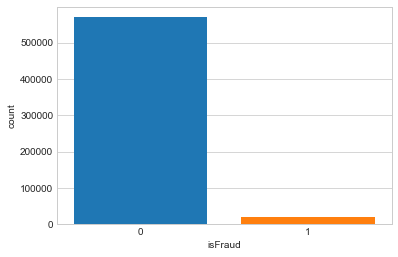

In [111]:
ax = sns.countplot(x='isFraud', data=min_train, saturation = 2)

In [112]:
min_train[['TransactionDT']]

,TransactionDT
0,86400
1,86401
2,86469
3,86499
4,86506
...,...
590535,15811047
590536,15811049
590537,15811079
590538,15811088


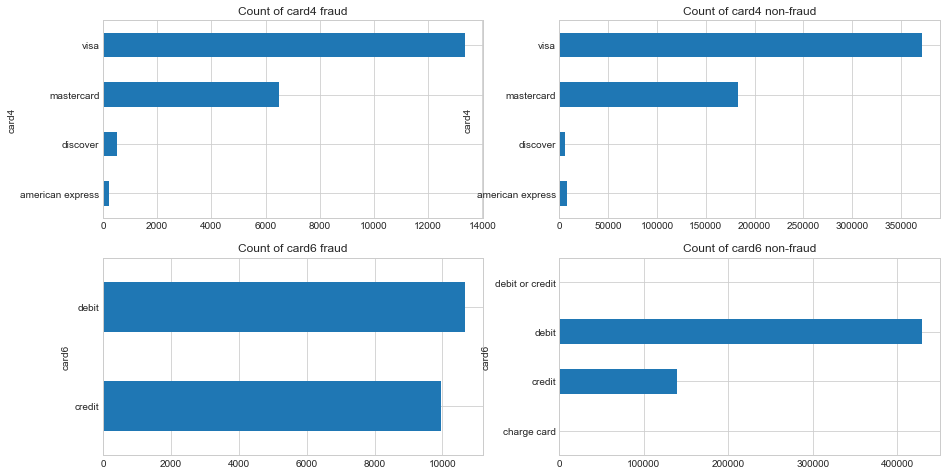

In [114]:
# Umschreiben + Kernel
train_transaction_fr = min_train.loc[train_transaction['isFraud'] == 1]
train_transaction_nofr = min_train.loc[train_transaction['isFraud'] == 0]
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 8))
train_transaction_fr.groupby('card4')['card4'].count().plot(kind='barh', ax=ax1, title='Count of card4 fraud')
train_transaction_nofr.groupby('card4')['card4'].count().plot(kind='barh', ax=ax2, title='Count of card4 non-fraud')
train_transaction_fr.groupby('card6')['card6'].count().plot(kind='barh', ax=ax3, title='Count of card6 fraud')
train_transaction_nofr.groupby('card6')['card6'].count().plot(kind='barh', ax=ax4, title='Count of card6 non-fraud')
plt.show()

In [15]:
# WIr müssen den abändern, den block in 3 teile unterteilen

y_train = train['isFraud'].copy()

#del train_transaction, train_identity, test_transaction, test_identity

# Drop target, fill in NaNs
X_train = train.drop('isFraud', axis=1)

X_test = test.copy()



# https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.LabelEncoder.html

# Label Encoding
for f in X_train.columns:
    if X_train[f].dtype=='object' or X_test[f].dtype=='object': 
        lbl = preprocessing.LabelEncoder()
        lbl.fit(list(X_train[f].values) + list(X_test[f].values))
        X_train[f] = lbl.transform(list(X_train[f].values))
        X_test[f] = lbl.transform(list(X_test[f].values))   

# Cleaning NA Values

In [16]:
# idea f rom thissource: https://scikit-learn.org/stable/modules/generated/sklearn.impute.SimpleImputer.html
import numpy as np
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

from sklearn.impute import SimpleImputer
from sklearn.impute import IterativeImputer
from sklearn.linear_model import BayesianRidge
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.neighbors import KNeighborsRegressor

 # estimators: BayesianRidge(), DecisionTreeRegressor(max_features='sqrt', random_state=0), 
 # ExtraTreesRegressor(n_estimators=10, random_state=0),
 # KNeighborsRegressor(n_neighbors=15)

imp = IterativeImputer(estimator = BayesianRidge(), 
                       missing_values=np.nan, 
                       sample_posterior=False, 
                       max_iter=10, 
                       tol=0.001, 
                       n_nearest_features=10, # amount of features,
                       imputation_order = 'ascending',
                       min_value = None,
                       max_value = None, 
                       verbose = 2, # controls the debug messages 
                       random_state = None,
                       add_indicator = True,
                       initial_strategy='mean')
imp.fit(X_train)
imputed_train = pd.DataFrame(data=imp.transform(X_train),
                             dtype='int')

[IterativeImputer] Completing matrix with shape (590540, 57)
[IterativeImputer] Ending imputation round 1/10, elapsed time 0.58
[IterativeImputer] Early stopping criterion reached.
[IterativeImputer] Completing matrix with shape (590540, 57)


In [17]:
imp.fit(X_test)
imputed_test = pd.DataFrame(data=imp.transform(X_test),
                             dtype='int')

[IterativeImputer] Completing matrix with shape (506691, 57)
[IterativeImputer] Ending imputation round 1/10, elapsed time 0.55
[IterativeImputer] Early stopping criterion reached.
[IterativeImputer] Completing matrix with shape (506691, 57)


# Saving the Datafiles to perform in google Colabs

In [58]:
imputed_test.to_csv('X_test.csv')
imputed_train.to_csv('X_train.csv')
y_train.to_csv('y_train.csv')


# First implementation of XG-Boost
small dataset

In [ ]:
xgb1 = XGBClassifier(
 learning_rate =0.1,
 n_estimators=1000,
 max_depth=3, # Typical values: 3-10 also for over and underfitting .... max of trees ... high deduced overfitting
 min_child_weight=1, #over or underfitting / to low = overfitting, to high underfitting
 gamma=0,
 subsample=0.8, # Lower values make the algorithm more conservative and prevents overfitting but too small values might lead to under-fitting. Typical values: 0.5-1
 colsample_bytree=0.8,
 objective= 'binary:logistic',
 nthread=4,
 scale_pos_weight=1,
 tree_method='exact')  #seed= 27

xgb1.fit(X_train, y_train)

In [107]:
dtrain_predprob = pd.DataFrame(xgb1.predict_proba(X_test)[:,1])
dtrain_predprob

,0
0,0.000615
1,0.000140
2,0.000738
3,0.000350
4,0.000423
...,...
995,0.000156
996,0.000118
997,0.003923
998,0.010783


# Feature Engineering

In [119]:
target = 'isFraud'
IDcol = '0'

In [126]:
# Source: Combination out of: 
# https://www.analyticsvidhya.com/blog/2016/03/complete-guide-parameter-tuning-xgboost-with-codes-python/
# & Graphic : https://machinelearningmastery.com/feature-importance-and-feature-selection-with-xgboost-in-python/

def modelfit(alg, dtrain, y_train, X_test, useTrainCV=True, cv_folds=5, early_stopping_rounds=50):
    
    if useTrainCV:
        xgb_param = alg.get_xgb_params()
        xgtrain = xgb.DMatrix(dtrain.values, label=y_train.values)
        cvresult = xgb.cv(xgb_param, xgtrain, num_boost_round=alg.get_params()['n_estimators'], nfold=cv_folds,
            metrics='auc', early_stopping_rounds=early_stopping_rounds)
        alg.set_params(n_estimators=cvresult.shape[0])
    
    #Fit the algorithm on the data
    alg.fit(dtrain, y_train,eval_metric='auc')
        
    #Predict training set:
    dtrain_predictions = alg.predict(dtrain)
    dtrain_predprob = alg.predict_proba(dtrain)[:,1]
        
    #Print model report:
    print ("\nModel Report")
    print ("Accuracy : %.4g" % metrics.accuracy_score(y_train.values, dtrain_predictions))
    print ("ROC_AUC Score: %f" % metrics.roc_auc_score(y_train.values, dtrain_predprob))
    
    xgb.plot_importance(alg, max_num_features=10) #nice function of XG Boost to plot the most important features
    

In [127]:
#Choose all predictors except target & IDcols
rcParams['figure.figsize'] = 17, 10
rcParams['font.size'] = 15

#predictors = [x for x in xg_df.columns if x not in [target, IDcol]]
xgb1 = XGBClassifier(
 learning_rate =0.1,
 n_estimators=1000,
 max_depth=3, # Typical values: 3-10 also for over and underfitting .... max of trees ... high deduced overfitting
 min_child_weight=1, #over or underfitting / to low = overfitting, to high underfitting
 gamma=0,
 subsample=0.8, # Lower values make the algorithm more conservative and prevents overfitting but too small values might lead to under-fitting. Typical values: 0.5-1
 colsample_bytree=0.8,
 objective= 'binary:logistic',
 nthread=4,
 scale_pos_weight=1)



Model Report
Accuracy : 0.988
ROC_AUC Score: 0.966362


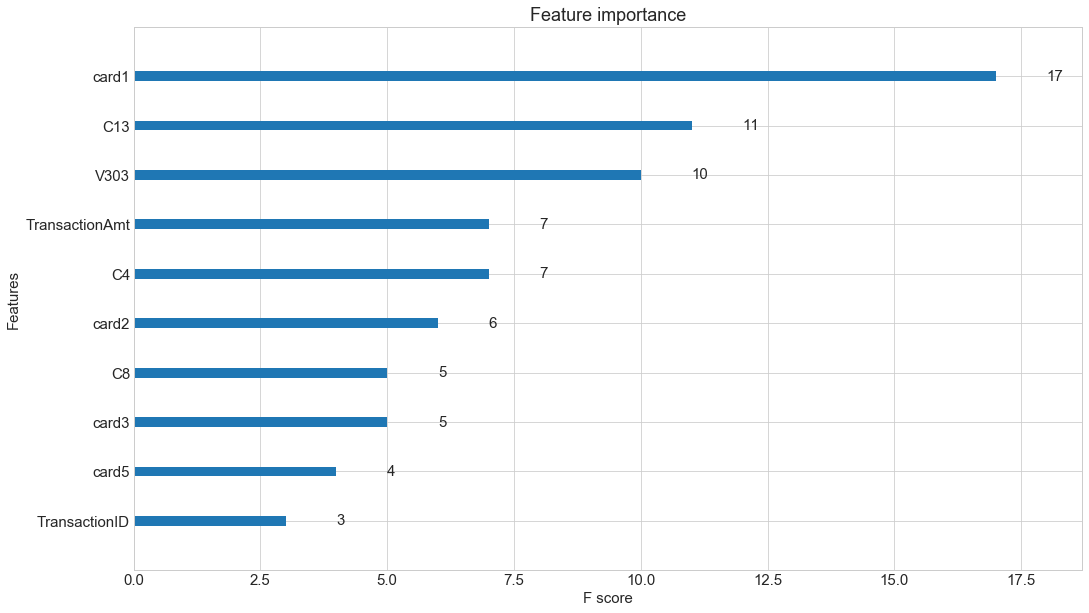

In [128]:
modelfit(xgb1, X_train, y_train, X_test)

# XG Boost with whole Dataset

In [19]:
# Getting The Whole Dataset
X_test = X_testo
X_train = X_traino
y_train =  y_traino
sub = subo 

In [20]:
xgb1 = XGBClassifier(
 learning_rate =0.1,
 n_estimators=1000,
 max_depth=8, # Typical values: 3-10 also for over and underfitting .... max of trees ... high deduced overfitting
 min_child_weight=1, #over or underfitting / to low = overfitting, to high underfitting
 gamma=0,
 #subsample=0.8, # Lower values make the algorithm more conservative and prevents overfitting but too small values might lead to under-fitting. Typical values: 0.5-1
 #colsample_bytree=0.8,
 #objective= 'binary:logistic',
 #nthread=4,
 #scale_pos_weight=1,
 #tree_method='exact'
 )  #seed= 27

xgb1.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=8,
              min_child_weight=1, missing=None, n_estimators=1000, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

In [21]:
dtrain_predprob = pd.DataFrame(xgb1.predict_proba(X_test)[:,1])
dtrain_predprob

,0
0,0.000113
1,0.000528
2,0.000191
3,0.000526
4,0.000007
...,...
506686,0.001031
506687,0.001189
506688,0.001687
506689,0.000531


In [24]:
sample_submission['isFraud'] = dtrain_predprob
sample_submission.to_csv('1samplsub.csv')

In [25]:
len(sample_submission)

506691

In [26]:
sample_submission.head()

,TransactionID,isFraud
0,3663549,0.000113
1,3663550,0.000528
2,3663551,0.000191
3,3663552,0.000526
4,3663553,0.000007


In [27]:
samplsub = sample_submission.set_index('TransactionID')
samplsub.to_csv('1samplsub.csv')

In [28]:
samplsub.head()

,isFraud
TransactionID,
3663549,0.000113
3663550,0.000528
3663551,0.000191
3663552,0.000526
3663553,0.000007


### Next Try with different Parameters

In [29]:
xgb1 = XGBClassifier(
 learning_rate =0.01,
 n_estimators=1000,
 max_depth=10, # Typical values: 3-10 also for over and underfitting .... max of trees ... high deduced overfitting
 min_child_weight=1, #over or underfitting / to low = overfitting, to high underfitting
 gamma=0,
 #subsample=0.8, # Lower values make the algorithm more conservative and prevents overfitting but too small values might lead to under-fitting. Typical values: 0.5-1
 #colsample_bytree=0.8,
 #objective= 'binary:logistic',
 #nthread=4,
 #scale_pos_weight=1,
 #tree_method='exact'
 )  #seed= 27

xgb1.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.01, max_delta_step=0, max_depth=10,
              min_child_weight=1, missing=None, n_estimators=1000, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

In [30]:
dtrain_predprob = pd.DataFrame(xgb1.predict_proba(X_test)[:,1])
dtrain_predprob

,0
0,0.004113
1,0.005497
2,0.004442
3,0.007483
4,0.003342
...,...
506686,0.014615
506687,0.020854
506688,0.010575
506689,0.008402


In [31]:
sample_submission['isFraud'] = dtrain_predprob
samplsub = sample_submission.set_index('TransactionID')
samplsub

,isFraud
TransactionID,
3663549,0.004113
3663550,0.005497
3663551,0.004442
3663552,0.007483
3663553,0.003342
...,...
4170235,0.014615
4170236,0.020854
4170237,0.010575


#### Next Try with min child weight = 5

In [33]:
xgb1 = XGBClassifier(
 learning_rate =0.01,
 n_estimators=1000,
 max_depth=10, # Typical values: 3-10 also for over and underfitting .... max of trees ... high deduced overfitting
 min_child_weight=5, #over or underfitting / to low = overfitting, to high underfitting
 gamma=0,
 #subsample=0.8, # Lower values make the algorithm more conservative and prevents overfitting but too small values might lead to under-fitting. Typical values: 0.5-1
 #colsample_bytree=0.8,
 #objective= 'binary:logistic',
 #nthread=4,
 #scale_pos_weight=1,
 #tree_method='exact'
 )  #seed= 27

xgb1.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.01, max_delta_step=0, max_depth=10,
              min_child_weight=5, missing=None, n_estimators=1000, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

In [34]:
dtrain_predprob = pd.DataFrame(xgb1.predict_proba(X_test)[:,1])
dtrain_predprob

,0
0,0.004902
1,0.007875
2,0.004850
3,0.005780
4,0.003605
...,...
506686,0.014293
506687,0.015407
506688,0.012124
506689,0.009282


In [35]:
sample_submission['isFraud'] = dtrain_predprob
samplsub = sample_submission.set_index('TransactionID')
samplsub

,isFraud
TransactionID,
3663549,0.004902
3663550,0.007875
3663551,0.004850
3663552,0.005780
3663553,0.003605
...,...
4170235,0.014293
4170236,0.015407
4170237,0.012124
